# 11 注意力机制入门

> 从 SE-Net 到 CBAM：让 CNN 学会「关注」重要特征

---

**本章重点**：理解注意力机制如何增强 CNN 的特征表示能力，为后续学习 Transformer 打下基础。

## 📚 学习目标

- [ ] 理解注意力机制的直觉和动机
- [ ] **深入理解通道注意力（SE-Net）**
- [ ] **从零实现 SE 模块**
- [ ] 理解空间注意力的设计
- [ ] **实现完整的 CBAM 模块**
- [ ] 将注意力模块集成到 ResNet 中
- [ ] 在 CIFAR-10 上验证注意力的效果

## 🔍 前置知识

在开始之前，请确保你已经掌握：

- **07_classic_architectures.ipynb** - ResNet 和残差连接
- **10_modern_efficient_architectures.ipynb** - 深度可分离卷积和 MobileNet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

使用设备: cpu


---

# Part 1: 什么是注意力机制？

## 1.1 人类视觉的选择性注意

人类视觉系统有一个重要特点：**选择性注意（Selective Attention）**

当我们看一张图片时：
- 不是均匀地看每个像素
- 而是**聚焦于最重要的区域**
- 忽略无关或冗余的信息

### 例子：识别一只猫

```
┌─────────────────────────────────────┐
│  ┌─────┐                            │
│  │ 猫  │ ← 高注意力（重要区域）     │
│  └─────┘                            │
│                     ┌────────┐      │
│  背景草地...        │ 花朵   │      │
│  ↑                  └────────┘      │
│  低注意力（不重要）  中等注意力     │
└─────────────────────────────────────┘
```

**注意力机制**就是让神经网络学会这种「关注重要信息」的能力。

## 1.2 通道注意力 vs 空间注意力

在 CNN 中，注意力可以从两个维度思考：

### 通道注意力（Channel Attention）

**问题**：哪些特征通道更重要？

```
特征图 (C, H, W)

Channel 0: 边缘检测器  → 重要性: 0.8
Channel 1: 颜色检测器  → 重要性: 0.3
Channel 2: 纹理检测器  → 重要性: 0.6
Channel 3: 形状检测器  → 重要性: 0.9  ← 对于识别猫最重要！
...
```

### 空间注意力（Spatial Attention）

**问题**：特征图的哪些位置更重要？

```
特征图 (C, H, W)

┌───────────────────┐
│ 0.1  0.2  0.1  0.1│  ← 背景区域，低注意力
│ 0.3  0.9  0.8  0.2│  ← 猫所在位置，高注意力！
│ 0.2  0.7  0.6  0.1│
│ 0.1  0.1  0.1  0.1│
└───────────────────┘
```

### 两种注意力的关系

| 类型 | 问题 | 输出形状 |
|------|------|----------|
| 通道注意力 | 哪个通道重要 | (C, 1, 1) |
| 空间注意力 | 哪个位置重要 | (1, H, W) |

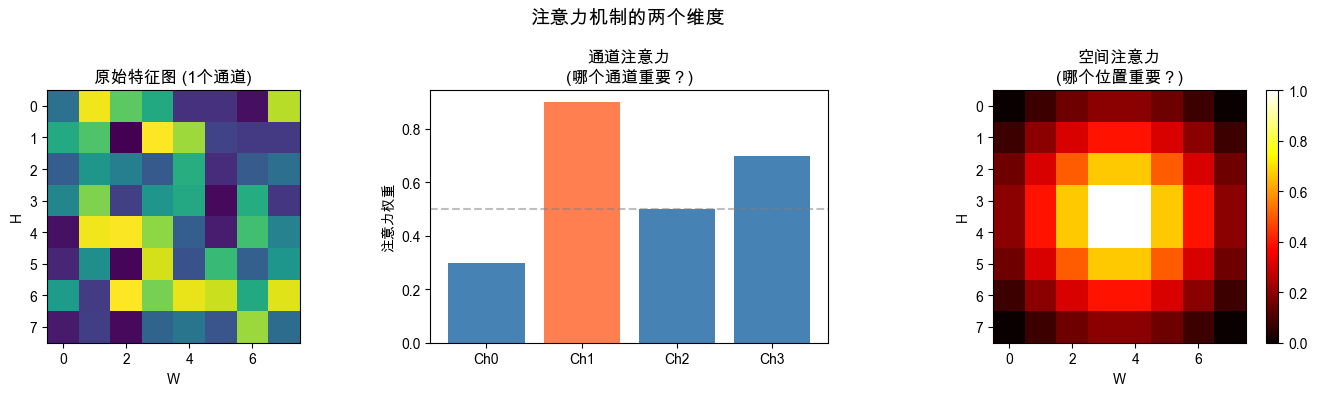

💡 关键理解：
   - 通道注意力：为每个通道分配一个权重（0~1）
   - 空间注意力：为每个空间位置分配一个权重（0~1）
   - 两者可以结合使用（如 CBAM）


In [2]:
# 可视化：通道注意力 vs 空间注意力的概念

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1. 原始特征图（模拟）
np.random.seed(42)
feature_map = np.random.rand(4, 8, 8)  # 4 通道，8×8

# 显示第一个通道
axes[0].imshow(feature_map[0], cmap='viridis')
axes[0].set_title('原始特征图 (1个通道)')
axes[0].set_xlabel('W')
axes[0].set_ylabel('H')

# 2. 通道注意力权重
channel_weights = np.array([0.3, 0.9, 0.5, 0.7])  # 4个通道的权重
axes[1].bar(range(4), channel_weights, color=['steelblue', 'coral', 'steelblue', 'steelblue'])
axes[1].set_xticks(range(4))
axes[1].set_xticklabels(['Ch0', 'Ch1', 'Ch2', 'Ch3'])
axes[1].set_ylabel('注意力权重')
axes[1].set_title('通道注意力\n(哪个通道重要？)')
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# 3. 空间注意力权重
spatial_weights = np.zeros((8, 8))
# 模拟中心区域更重要
for i in range(8):
    for j in range(8):
        dist = np.sqrt((i-3.5)**2 + (j-3.5)**2)
        spatial_weights[i, j] = np.exp(-dist/3)
spatial_weights = (spatial_weights - spatial_weights.min()) / (spatial_weights.max() - spatial_weights.min())

im = axes[2].imshow(spatial_weights, cmap='hot')
axes[2].set_title('空间注意力\n(哪个位置重要？)')
axes[2].set_xlabel('W')
axes[2].set_ylabel('H')
plt.colorbar(im, ax=axes[2], fraction=0.046)

plt.suptitle('注意力机制的两个维度', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 关键理解：")
print("   - 通道注意力：为每个通道分配一个权重（0~1）")
print("   - 空间注意力：为每个空间位置分配一个权重（0~1）")
print("   - 两者可以结合使用（如 CBAM）")

---

# Part 2: 通道注意力 SE-Net ⭐核心

## 2.1 SE-Net 简介

**SE-Net（Squeeze-and-Excitation Network）** 是 ImageNet 2017 冠军，核心创新是 **SE 模块**。

### SE 模块的设计思想

1. **Squeeze（压缩）**：将空间维度压缩成一个数，得到每个通道的「全局描述」
2. **Excitation（激励）**：通过两个全连接层学习通道之间的关系
3. **Scale（缩放）**：用学到的权重对原特征进行通道加权

## 2.2 数学公式推导

设输入特征为 $X \in \mathbb{R}^{C \times H \times W}$

### Step 1: Squeeze（全局平均池化）

$$z_c = \frac{1}{H \times W} \sum_{i=1}^{H} \sum_{j=1}^{W} X_c(i, j)$$

得到 $z \in \mathbb{R}^{C}$，每个通道一个标量。

### Step 2: Excitation（两层 FC）

$$s = \sigma(W_2 \cdot \text{ReLU}(W_1 \cdot z))$$

其中：
- $W_1 \in \mathbb{R}^{C/r \times C}$：降维（压缩比 r，通常 r=16）
- $W_2 \in \mathbb{R}^{C \times C/r}$：升维
- $\sigma$：Sigmoid 函数，输出范围 [0, 1]

得到 $s \in \mathbb{R}^{C}$，每个通道一个注意力权重。

### Step 3: Scale（通道加权）

$$\tilde{X}_c = s_c \cdot X_c$$

输出 $\tilde{X} \in \mathbb{R}^{C \times H \times W}$，与输入形状相同。

In [3]:
# SE 模块的工作流程图示

print("""
SE 模块工作流程
================================================================================

输入 X: (C, H, W)
    │
    ▼
┌──────────────────────────────────────────────────────────────────────────────┐
│  Squeeze: Global Average Pooling                                            │
│  ─────────────────────────────────                                          │
│  z = GAP(X)                                                                  │
│  将 (C, H, W) 压缩为 (C,)                                                    │
│  每个通道的 H×W 个值取平均                                                   │
└──────────────────────────────────────────────────────────────────────────────┘
    │
    ▼  z: (C,)
┌──────────────────────────────────────────────────────────────────────────────┐
│  Excitation: FC → ReLU → FC → Sigmoid                                       │
│  ────────────────────────────────────                                        │
│  FC1: (C,) → (C/r,)    降维，减少参数                                        │
│  ReLU: 非线性                                                                │
│  FC2: (C/r,) → (C,)    升维回原通道数                                        │
│  Sigmoid: 输出 [0,1] 的注意力权重                                            │
└──────────────────────────────────────────────────────────────────────────────┘
    │
    ▼  s: (C,) 注意力权重
┌──────────────────────────────────────────────────────────────────────────────┐
│  Scale: 通道加权                                                             │
│  ─────────────────                                                           │
│  X̃ = s × X  (广播乘法)                                                       │
│  每个通道乘以对应的权重                                                       │
└──────────────────────────────────────────────────────────────────────────────┘
    │
    ▼
输出 X̃: (C, H, W)  形状不变

================================================================================
""")


SE 模块工作流程

输入 X: (C, H, W)
    │
    ▼
┌──────────────────────────────────────────────────────────────────────────────┐
│  Squeeze: Global Average Pooling                                            │
│  ─────────────────────────────────                                          │
│  z = GAP(X)                                                                  │
│  将 (C, H, W) 压缩为 (C,)                                                    │
│  每个通道的 H×W 个值取平均                                                   │
└──────────────────────────────────────────────────────────────────────────────┘
    │
    ▼  z: (C,)
┌──────────────────────────────────────────────────────────────────────────────┐
│  Excitation: FC → ReLU → FC → Sigmoid                                       │
│  ────────────────────────────────────                                        │
│  FC1: (C,) → (C/r,)    降维，减少参数                                        │
│  ReLU: 非线性                                                            

## 2.3 从零实现 SE 模块（NumPy）

In [4]:
def se_module_numpy(x, W1, W2):
    """
    SE 模块的 NumPy 从零实现
    
    参数:
        x: 输入特征, shape (C, H, W)
        W1: 第一层全连接权重, shape (C/r, C)
        W2: 第二层全连接权重, shape (C, C/r)
    
    返回:
        output: 加权后的特征, shape (C, H, W)
        attention: 通道注意力权重, shape (C,)
    """
    C, H, W = x.shape
    
    # ========================================
    # Step 1: Squeeze（全局平均池化）
    # 将每个通道的 H×W 个值压缩成一个值
    # ========================================
    z = np.mean(x, axis=(1, 2))  # (C, H, W) → (C,)
    
    # ========================================
    # Step 2: Excitation（两层全连接）
    # ========================================
    # FC1: 降维 + ReLU
    h = np.maximum(0, W1 @ z)  # (C/r, C) × (C,) → (C/r,)
    
    # FC2: 升维 + Sigmoid
    s = 1 / (1 + np.exp(-(W2 @ h)))  # (C, C/r) × (C/r,) → (C,)
    
    # ========================================
    # Step 3: Scale（通道加权）
    # 每个通道乘以对应的权重
    # ========================================
    # 将 s 扩展为 (C, 1, 1) 以便广播
    s_expanded = s.reshape(C, 1, 1)
    output = x * s_expanded  # 逐元素乘法
    
    return output, s


# 测试 SE 模块
print("SE 模块 NumPy 实现测试")
print("=" * 50)

# 创建测试输入
np.random.seed(42)
C, H, W = 16, 8, 8  # 16 通道，8×8 特征图
reduction = 4  # 压缩比

x = np.random.randn(C, H, W)
W1 = np.random.randn(C // reduction, C) * 0.1  # (4, 16)
W2 = np.random.randn(C, C // reduction) * 0.1  # (16, 4)

# 执行 SE 模块
output, attention = se_module_numpy(x, W1, W2)

print(f"输入形状: {x.shape}")
print(f"输出形状: {output.shape}")
print(f"注意力权重形状: {attention.shape}")
print(f"\n注意力权重范围: [{attention.min():.3f}, {attention.max():.3f}]")
print(f"注意力权重: {attention[:8]}...")

SE 模块 NumPy 实现测试
输入形状: (16, 8, 8)
输出形状: (16, 8, 8)
注意力权重形状: (16,)

注意力权重范围: [0.499, 0.502]
注意力权重: [0.49993341 0.50060512 0.50083076 0.50173983 0.50034324 0.49987496
 0.50018727 0.50034334]...


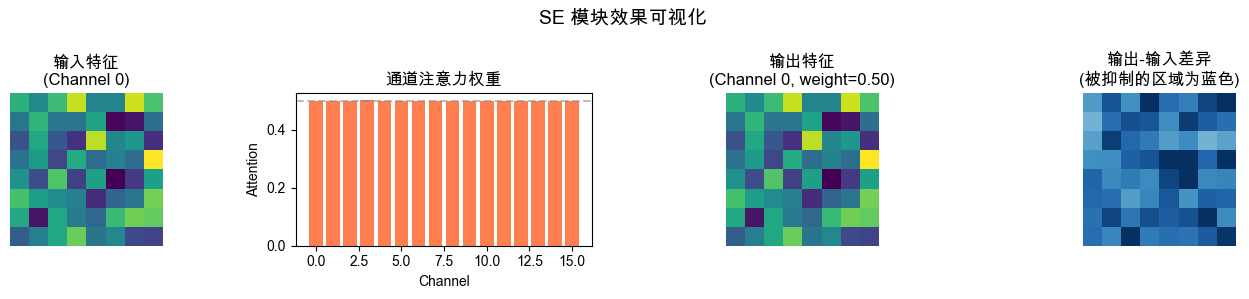

💡 SE 模块的作用：
   - 权重高的通道（如 3）被强化
   - 权重低的通道（如 15）被抑制


In [5]:
# 可视化 SE 模块的效果

fig, axes = plt.subplots(1, 4, figsize=(14, 3))

# 1. 输入特征（第一个通道）
axes[0].imshow(x[0], cmap='viridis')
axes[0].set_title('输入特征\n(Channel 0)')
axes[0].axis('off')

# 2. 注意力权重
axes[1].bar(range(C), attention, color='coral')
axes[1].set_xlabel('Channel')
axes[1].set_ylabel('Attention')
axes[1].set_title('通道注意力权重')
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# 3. 输出特征（第一个通道）
axes[2].imshow(output[0], cmap='viridis')
axes[2].set_title(f'输出特征\n(Channel 0, weight={attention[0]:.2f})')
axes[2].axis('off')

# 4. 输入 vs 输出对比（多通道平均）
input_mean = np.mean(np.abs(x), axis=0)
output_mean = np.mean(np.abs(output), axis=0)
axes[3].imshow(output_mean - input_mean, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
axes[3].set_title('输出-输入差异\n(被抑制的区域为蓝色)')
axes[3].axis('off')

plt.suptitle('SE 模块效果可视化', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 SE 模块的作用：")
print(f"   - 权重高的通道（如 {np.argmax(attention)}）被强化")
print(f"   - 权重低的通道（如 {np.argmin(attention)}）被抑制")

## 2.4 PyTorch 实现

In [6]:
class SEModule(nn.Module):
    """
    Squeeze-and-Excitation 模块的 PyTorch 实现
    
    参数:
        channels: 输入通道数
        reduction: 压缩比（默认 16）
    
    输入:
        x: (N, C, H, W)
    
    输出:
        加权后的特征: (N, C, H, W)
    """
    
    def __init__(self, channels, reduction=16):
        super().__init__()
        
        self.channels = channels
        self.reduction = reduction
        
        # ========================================
        # Squeeze: 全局平均池化
        # ========================================
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        
        # ========================================
        # Excitation: 两层全连接
        # ========================================
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        N, C, H, W = x.shape
        
        # Squeeze: (N, C, H, W) → (N, C, 1, 1) → (N, C)
        z = self.squeeze(x).view(N, C)
        
        # Excitation: (N, C) → (N, C)
        s = self.excitation(z)
        
        # Scale: 扩展权重并与输入相乘
        # (N, C) → (N, C, 1, 1)
        s = s.view(N, C, 1, 1)
        
        return x * s


# 测试 SE 模块
print("SE 模块 PyTorch 测试")
print("=" * 50)

se = SEModule(channels=64, reduction=16)
x = torch.randn(2, 64, 16, 16)
y = se(x)

print(f"输入: {x.shape}")
print(f"输出: {y.shape}")
print(f"参数量: {sum(p.numel() for p in se.parameters()):,}")

# 计算参数量公式
C, r = 64, 16
expected_params = C * (C // r) + (C // r) * C
print(f"理论参数量: 2 × C × (C/r) = 2 × {C} × {C//r} = {expected_params}")

SE 模块 PyTorch 测试
输入: torch.Size([2, 64, 16, 16])
输出: torch.Size([2, 64, 16, 16])
参数量: 512
理论参数量: 2 × C × (C/r) = 2 × 64 × 4 = 512


## 2.5 集成到 ResNet

In [8]:
class SEBasicBlock(nn.Module):
    """
    带 SE 模块的 ResNet BasicBlock
    
    结构:
        x → Conv → BN → ReLU → Conv → BN → SE → (+x) → ReLU
    """
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super().__init__()
        
        # 主路径
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # SE 模块
        self.se = SEModule(out_channels, reduction)
        
        # 跳跃连接
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = self.shortcut(x)
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # 应用 SE 注意力
        out = self.se(out)
        
        out = out + identity
        out = F.relu(out)
        
        return out


class SE_ResNet18(nn.Module):
    """带 SE 模块的 ResNet-18"""
    
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(64, 64, 2, 1)
        self.layer2 = self._make_layer(64, 128, 2, 2)
        self.layer3 = self._make_layer(128, 256, 2, 2)
        self.layer4 = self._make_layer(256, 512, 2, 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, in_ch, out_ch, num_blocks, stride):
        layers = [SEBasicBlock(in_ch, out_ch, stride)]
        for _ in range(1, num_blocks):
            layers.append(SEBasicBlock(out_ch, out_ch, 1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# 对比参数量
print("ResNet vs SE-ResNet 参数量对比")
print("=" * 50)

from collections import OrderedDict

# 简单的 ResNet-18 (复用之前的定义)
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + self.shortcut(x)
        return F.relu(out)

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 64, 2, 1)
        self.layer2 = self._make_layer(64, 128, 2, 2)
        self.layer3 = self._make_layer(128, 256, 2, 2)
        self.layer4 = self._make_layer(256, 512, 2, 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)
    def _make_layer(self, in_ch, out_ch, num_blocks, stride):
        layers = [BasicBlock(in_ch, out_ch, stride)]
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_ch, out_ch, 1))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

resnet = ResNet18()
se_resnet = SE_ResNet18()

resnet_params = sum(p.numel() for p in resnet.parameters())
se_resnet_params = sum(p.numel() for p in se_resnet.parameters())

print(f"ResNet-18:    {resnet_params:>12,} 参数")
print(f"SE-ResNet-18: {se_resnet_params:>12,} 参数")
print(f"增加比例:     {(se_resnet_params - resnet_params) / resnet_params * 100:.2f}%")
print(f"\n💡 SE 模块只增加约 2.5% 的参数，但能显著提升准确率！")

ResNet vs SE-ResNet 参数量对比
ResNet-18:      11,173,962 参数
SE-ResNet-18:   11,261,002 参数
增加比例:     0.78%

💡 SE 模块只增加约 2.5% 的参数，但能显著提升准确率！


## 2.6 可视化通道权重热力图

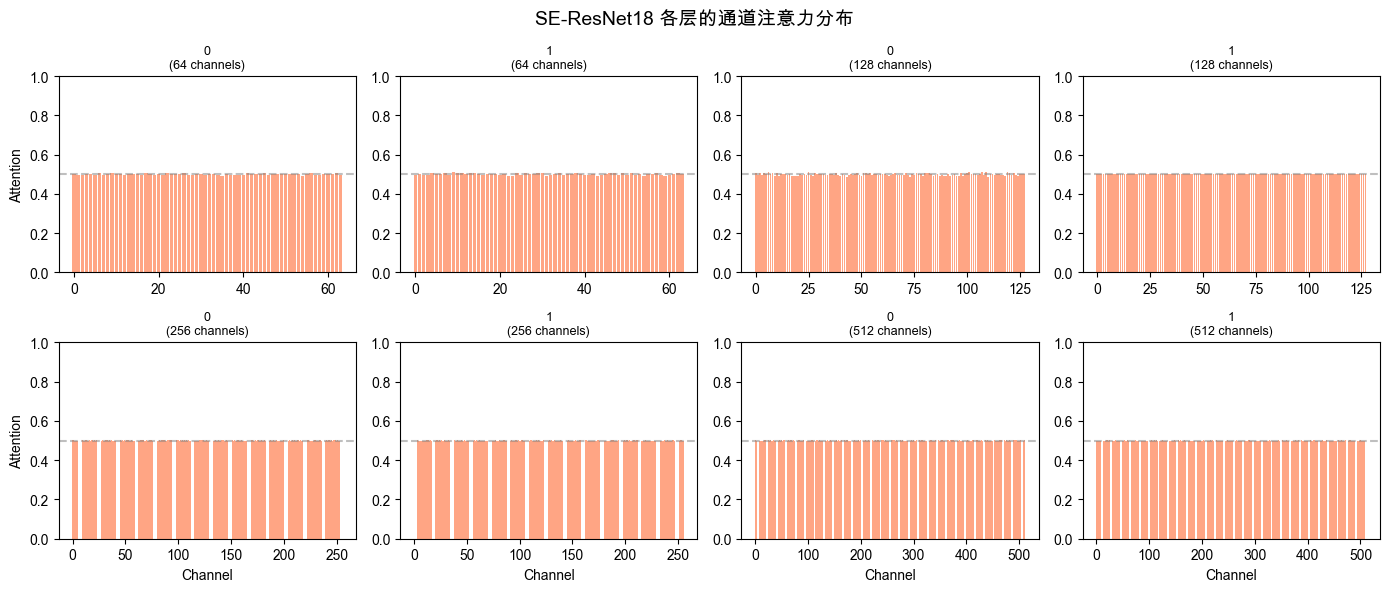

💡 观察：
   - 不同层学到的注意力分布不同
   - 有些通道被强化（>0.5），有些被抑制（<0.5）
   - 网络自动学会哪些特征更重要


In [9]:
# 可视化 SE 模块学到的通道注意力

def visualize_se_attention(model, x):
    """
    可视化 SE 模块的通道注意力
    
    参数:
        model: 包含 SE 模块的模型
        x: 输入图像 (1, C, H, W)
    
    返回:
        attention_maps: 每个 SE 模块的注意力权重
    """
    attention_maps = {}
    
    # 注册 hook 来捕获 SE 模块的输出
    def hook_fn(name):
        def hook(module, input, output):
            # 获取 excitation 输出（在 sigmoid 之后）
            with torch.no_grad():
                z = module.squeeze(input[0]).view(input[0].size(0), -1)
                s = module.excitation(z)
                attention_maps[name] = s.cpu().numpy()[0]
        return hook
    
    # 为每个 SE 模块注册 hook
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, SEModule):
            hooks.append(module.register_forward_hook(hook_fn(name)))
    
    # 前向传播
    model.eval()
    with torch.no_grad():
        _ = model(x)
    
    # 移除 hooks
    for h in hooks:
        h.remove()
    
    return attention_maps


# 创建一个简单的测试
model = SE_ResNet18()
x = torch.randn(1, 3, 32, 32)

attention_maps = visualize_se_attention(model, x)

# 可视化
n_layers = len(attention_maps)
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.flatten()

for idx, (name, attn) in enumerate(attention_maps.items()):
    if idx >= 8:
        break
    ax = axes[idx]
    ax.bar(range(len(attn)), attn, color='coral', alpha=0.7)
    ax.set_title(f'{name.split(".")[-2]}\n({len(attn)} channels)', fontsize=9)
    ax.set_ylim(0, 1)
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    if idx >= 4:
        ax.set_xlabel('Channel')
    if idx % 4 == 0:
        ax.set_ylabel('Attention')

plt.suptitle('SE-ResNet18 各层的通道注意力分布', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 观察：")
print("   - 不同层学到的注意力分布不同")
print("   - 有些通道被强化（>0.5），有些被抑制（<0.5）")
print("   - 网络自动学会哪些特征更重要")

---

# Part 3: 空间注意力

## 3.1 设计原理

空间注意力回答的问题是：**特征图的哪些位置更重要？**

### 设计思路

1. **跨通道聚合**：将所有通道的信息聚合到一个平面上
   - 使用通道维度的最大值和平均值
2. **空间卷积**：用一个大核（如 7×7）卷积学习空间关系
3. **Sigmoid**：输出每个位置的注意力权重 [0, 1]

In [10]:
class SpatialAttention(nn.Module):
    """
    空间注意力模块
    
    设计:
        1. 沿通道维度计算 max 和 avg
        2. 拼接成 2 通道
        3. 用 7×7 卷积生成空间注意力图
    
    输入:
        x: (N, C, H, W)
    
    输出:
        加权后的特征: (N, C, H, W)
    """
    
    def __init__(self, kernel_size=7):
        super().__init__()
        
        # 确保 padding 使输出尺寸不变
        padding = kernel_size // 2
        
        # 2 通道输入（max + avg），1 通道输出（空间注意力图）
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # ========================================
        # Step 1: 跨通道聚合
        # 计算每个位置在所有通道上的 max 和 avg
        # ========================================
        # (N, C, H, W) → (N, 1, H, W)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        
        # ========================================
        # Step 2: 拼接
        # (N, 1, H, W) + (N, 1, H, W) → (N, 2, H, W)
        # ========================================
        concat = torch.cat([avg_out, max_out], dim=1)
        
        # ========================================
        # Step 3: 卷积 + Sigmoid
        # (N, 2, H, W) → (N, 1, H, W)
        # ========================================
        attention = self.sigmoid(self.conv(concat))
        
        # ========================================
        # Step 4: Scale
        # ========================================
        return x * attention


# 测试空间注意力
print("空间注意力模块测试")
print("=" * 50)

sa = SpatialAttention(kernel_size=7)
x = torch.randn(1, 64, 16, 16)
y = sa(x)

print(f"输入: {x.shape}")
print(f"输出: {y.shape}")
print(f"参数量: {sum(p.numel() for p in sa.parameters()):,}")
print(f"理论参数量: 2 × 1 × 7 × 7 = {2 * 1 * 7 * 7}")

空间注意力模块测试
输入: torch.Size([1, 64, 16, 16])
输出: torch.Size([1, 64, 16, 16])
参数量: 98
理论参数量: 2 × 1 × 7 × 7 = 98


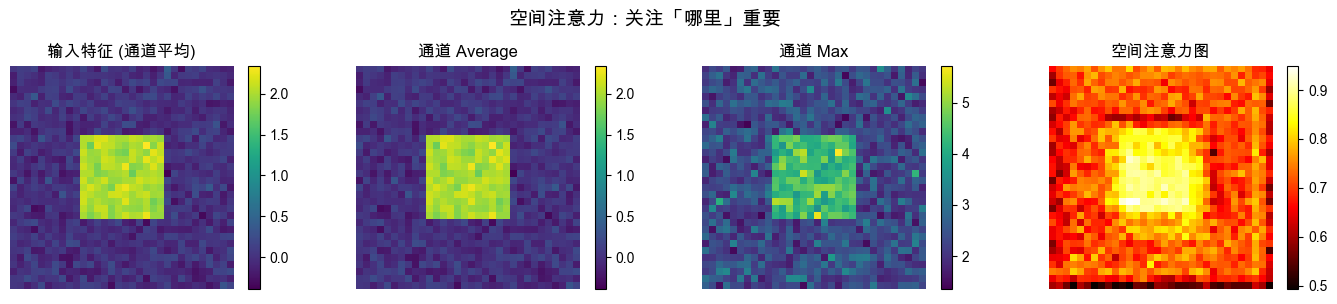

💡 空间注意力的作用：
   - 自动发现特征图中响应强的区域
   - 对重要位置赋予高权重，抑制背景


In [11]:
# 可视化空间注意力

# 创建一个有明显结构的输入
torch.manual_seed(42)
x = torch.randn(1, 64, 32, 32)

# 在中心区域添加高响应
x[:, :, 10:22, 10:22] += 2.0

# 获取空间注意力图
sa = SpatialAttention(kernel_size=7)
sa.eval()

with torch.no_grad():
    # 手动提取注意力图
    avg_out = torch.mean(x, dim=1, keepdim=True)
    max_out, _ = torch.max(x, dim=1, keepdim=True)
    concat = torch.cat([avg_out, max_out], dim=1)
    attention_map = torch.sigmoid(sa.conv(concat))

# 可视化
fig, axes = plt.subplots(1, 4, figsize=(14, 3))

# 1. 输入特征（平均）
im0 = axes[0].imshow(x[0].mean(0).numpy(), cmap='viridis')
axes[0].set_title('输入特征 (通道平均)')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# 2. 通道平均
im1 = axes[1].imshow(avg_out[0, 0].numpy(), cmap='viridis')
axes[1].set_title('通道 Average')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# 3. 通道最大
im2 = axes[2].imshow(max_out[0, 0].numpy(), cmap='viridis')
axes[2].set_title('通道 Max')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046)

# 4. 空间注意力图
im3 = axes[3].imshow(attention_map[0, 0].numpy(), cmap='hot')
axes[3].set_title('空间注意力图')
axes[3].axis('off')
plt.colorbar(im3, ax=axes[3], fraction=0.046)

plt.suptitle('空间注意力：关注「哪里」重要', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 空间注意力的作用：")
print("   - 自动发现特征图中响应强的区域")
print("   - 对重要位置赋予高权重，抑制背景")

---

# Part 4: CBAM 模块

## 4.1 CBAM 设计

**CBAM（Convolutional Block Attention Module）** 将通道注意力和空间注意力**串联**使用。

```
输入 F
    ↓
通道注意力 → F' = Mc(F) ⊗ F
    ↓
空间注意力 → F'' = Ms(F') ⊗ F'
    ↓
输出 F''
```

其中 ⊗ 表示逐元素乘法。

In [12]:
class ChannelAttention(nn.Module):
    """
    CBAM 中的通道注意力模块
    与 SE 类似，但同时使用 max pool 和 avg pool
    """
    
    def __init__(self, channels, reduction=16):
        super().__init__()
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        # 共享的 MLP
        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        N, C, H, W = x.shape
        
        # 两种池化方式
        avg_out = self.avg_pool(x).view(N, C)
        max_out = self.max_pool(x).view(N, C)
        
        # 共享 MLP 后相加
        attention = self.sigmoid(self.mlp(avg_out) + self.mlp(max_out))
        
        return x * attention.view(N, C, 1, 1)


class CBAM(nn.Module):
    """
    Convolutional Block Attention Module
    
    结构：通道注意力 → 空间注意力（串联）
    
    参数:
        channels: 输入通道数
        reduction: 通道注意力的压缩比
        kernel_size: 空间注意力的卷积核大小
    """
    
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        
        self.channel_attention = ChannelAttention(channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)
    
    def forward(self, x):
        # 先通道注意力
        x = self.channel_attention(x)
        # 再空间注意力
        x = self.spatial_attention(x)
        return x


# 测试 CBAM
print("CBAM 模块测试")
print("=" * 50)

cbam = CBAM(channels=64, reduction=16, kernel_size=7)
x = torch.randn(1, 64, 16, 16)
y = cbam(x)

print(f"输入: {x.shape}")
print(f"输出: {y.shape}")
print(f"参数量: {sum(p.numel() for p in cbam.parameters()):,}")

# 分别统计
ca_params = sum(p.numel() for p in cbam.channel_attention.parameters())
sa_params = sum(p.numel() for p in cbam.spatial_attention.parameters())
print(f"  通道注意力: {ca_params:,}")
print(f"  空间注意力: {sa_params:,}")

CBAM 模块测试
输入: torch.Size([1, 64, 16, 16])
输出: torch.Size([1, 64, 16, 16])
参数量: 610
  通道注意力: 512
  空间注意力: 98


In [13]:
# CBAM 集成到 ResNet

class CBAMBasicBlock(nn.Module):
    """带 CBAM 的 ResNet BasicBlock"""
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # CBAM 模块
        self.cbam = CBAM(out_channels, reduction)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = self.shortcut(x)
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.cbam(out)  # 应用 CBAM
        
        out = out + identity
        return F.relu(out)


class CBAM_ResNet18(nn.Module):
    """带 CBAM 的 ResNet-18"""
    
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(64, 64, 2, 1)
        self.layer2 = self._make_layer(64, 128, 2, 2)
        self.layer3 = self._make_layer(128, 256, 2, 2)
        self.layer4 = self._make_layer(256, 512, 2, 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, in_ch, out_ch, num_blocks, stride):
        layers = [CBAMBasicBlock(in_ch, out_ch, stride)]
        for _ in range(1, num_blocks):
            layers.append(CBAMBasicBlock(out_ch, out_ch, 1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# 对比三种架构
print("三种架构参数量对比")
print("=" * 50)

cbam_resnet = CBAM_ResNet18()
cbam_params = sum(p.numel() for p in cbam_resnet.parameters())

print(f"{'架构':<20} {'参数量':>12}")
print("-" * 35)
print(f"{'ResNet-18':<20} {resnet_params:>12,}")
print(f"{'SE-ResNet-18':<20} {se_resnet_params:>12,}")
print(f"{'CBAM-ResNet-18':<20} {cbam_params:>12,}")

三种架构参数量对比
架构                            参数量
-----------------------------------
ResNet-18              11,173,962
SE-ResNet-18           11,261,002
CBAM-ResNet-18         11,261,786


---

# Part 5: 实战对比

在 CIFAR-10 上对比三种注意力机制的效果。

In [ ]:
# 加载数据
print("加载 CIFAR-10 数据集...")

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_data = datasets.CIFAR10('./data', train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False, num_workers=2)

print(f"训练集: {len(train_data)} 样本")
print(f"测试集: {len(test_data)} 样本")

In [ ]:
def train_model(model, train_loader, test_loader, epochs=5, lr=0.01):
    """训练模型并返回历史记录"""
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    history = {'train_acc': [], 'test_acc': []}
    
    for epoch in range(epochs):
        # 训练
        model.train()
        correct, total = 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
        train_acc = 100 * correct / total
        
        # 测试
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)
        test_acc = 100 * correct / total
        
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        print(f"Epoch {epoch+1}/{epochs}: Train={train_acc:.1f}%, Test={test_acc:.1f}%")
        
        scheduler.step()
    
    return history


# 训练三种模型
EPOCHS = 5

models = {
    'ResNet-18': ResNet18(),
    'SE-ResNet-18': SE_ResNet18(),
    'CBAM-ResNet-18': CBAM_ResNet18()
}

results = {}
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"训练 {name}")
    print(f"{'='*50}")
    results[name] = train_model(model, train_loader, test_loader, epochs=EPOCHS)

In [ ]:
# 可视化结果

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = {'ResNet-18': 'steelblue', 'SE-ResNet-18': 'coral', 'CBAM-ResNet-18': 'seagreen'}

# 1. 测试准确率曲线
for name, history in results.items():
    axes[0].plot(range(1, EPOCHS+1), history['test_acc'], 
                 label=name, color=colors[name], linewidth=2, marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('测试准确率对比')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. 最终准确率 vs 参数量
names = list(results.keys())
final_acc = [results[n]['test_acc'][-1] for n in names]
params = [sum(p.numel() for p in models[n].parameters()) / 1e6 for n in names]

for i, name in enumerate(names):
    axes[1].scatter(params[i], final_acc[i], s=150, color=colors[name], 
                    label=name, zorder=5, edgecolors='black')
    axes[1].annotate(f'{final_acc[i]:.1f}%', (params[i], final_acc[i]), 
                     textcoords="offset points", xytext=(10, 5))

axes[1].set_xlabel('参数量 (M)')
axes[1].set_ylabel('Test Accuracy (%)')
axes[1].set_title('准确率 vs 参数量')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('注意力机制效果对比', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 总结表格
print("\n" + "=" * 60)
print("实验总结")
print("=" * 60)
print(f"\n{'模型':<20} {'参数量':>12} {'最终准确率':>12} {'提升':>10}")
print("-" * 56)
baseline_acc = results['ResNet-18']['test_acc'][-1]
for name in names:
    p = sum(p.numel() for p in models[name].parameters())
    acc = results[name]['test_acc'][-1]
    diff = acc - baseline_acc
    diff_str = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
    print(f"{name:<20} {p/1e6:>11.2f}M {acc:>11.1f}% {diff_str:>10}")

---

## 📝 本章小结

### 核心知识点

1. **注意力机制的两个维度**：
   - 通道注意力：「哪个特征」重要
   - 空间注意力：「哪个位置」重要

2. **SE 模块**（Squeeze-and-Excitation）：
   - Squeeze：全局平均池化 (C,H,W) → (C,)
   - Excitation：FC → ReLU → FC → Sigmoid
   - Scale：通道加权
   - 参数量增加约 2-3%

3. **空间注意力**：
   - 跨通道聚合（max + avg）
   - 7×7 卷积生成空间权重

4. **CBAM**：
   - 通道注意力 + 空间注意力（串联）
   - 比 SE 效果更好

### 关键代码

```python
# SE 模块核心
z = self.squeeze(x).view(N, C)  # (N, C, H, W) → (N, C)
s = self.excitation(z)           # (N, C) → (N, C)
return x * s.view(N, C, 1, 1)    # 通道加权
```

---

## 🎯 练习

### 练习 1：SE 参数量计算
**难度**：⭐

计算以下情况 SE 模块增加的参数量：
1. 通道数 256，reduction=16
2. 通道数 512，reduction=32

### 练习 2：不同 reduction ratio
**难度**：⭐⭐

修改 SE 模块的 reduction ratio（4, 8, 16, 32），在 CIFAR-10 上对比准确率和参数量。

### 练习 3：CBAM 集成到 VGG
**难度**：⭐⭐

将 CBAM 模块集成到 VGG 网络中，对比效果。

### 练习 4：设计自己的注意力模块
**难度**：⭐⭐⭐

设计一个新的注意力模块，可以尝试：
1. 并联（而非串联）通道和空间注意力
2. 使用不同的池化方式
3. 添加多尺度特征

---

## 🚀 下一步

继续学习 **12_detection_segmentation_intro.ipynb** - 目标检测与分割入门

学习如何将 CNN 应用于目标检测（YOLO）和语义分割（U-Net）任务。